# ANALYSIS DATASET FROM TESISQUARE

first of all we are going to import every library that we'll need during the project

In [24]:
'''
Libraries versions

pandas: 2.2.3
numpy: 2.2.2
seaborn 0.13.2
matplotlib: 3.10.0
scikit-learn: 1.6.1
geopy: 2.4.1
tqdm: 4.67.1
requests: 2.32.3
folium: 0.19.4
'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from geopy.geocoders import Nominatim
from typing import Optional, Tuple
from tqdm import tqdm
import requests
import mpu
import os
import json
import warnings
import requests
from datetime import datetime, timedelta
import csv
from geopy.distance import geodesic
import folium
import time


## Reading and checking information about the file

In [4]:
# Loading the dataset from a CSV file
data = pd.read_csv("./delivery_data.csv")

# Displaying dataset information (column types, non-null values, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14554 entries, 0 to 14553
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            14554 non-null  int64  
 1   SERVICETYPE           14340 non-null  object 
 2   VEHICLETYPE           14331 non-null  object 
 3   DEPARTURE_COUNTRY     14554 non-null  object 
 4   DEPARTURE_ZIPCODE     14548 non-null  float64
 5   ARRIVAL_COUNTRY       14554 non-null  object 
 6   ARRIVAL_ZIPCODE       14554 non-null  int64  
 7   SHIPPING_DATE         14554 non-null  object 
 8   GROSS_WEIGHT_KG       14554 non-null  float64
 9   NET_WEIGHT_KG         14554 non-null  float64
 10  VOLUME_M3             14554 non-null  float64
 11  DECLARED_DISTANCE_KM  11577 non-null  float64
 12  ACTUAL_DELIVERY_DATE  14554 non-null  object 
 13  DELIVERY_TIME_HH      14554 non-null  int64  
 14  WDAY                  14554 non-null  int64  
dtypes: float64(5), int6

First let’s see how many rows and columns our dataset is made up of. Next we look at what kind of features there are and check if there are columns with missing data.

In [5]:
# Displaying summary statistics of the dataset
data.describe()

,Unnamed: 0,DEPARTURE_ZIPCODE,ARRIVAL_ZIPCODE,GROSS_WEIGHT_KG,NET_WEIGHT_KG,VOLUME_M3,DECLARED_DISTANCE_KM,DELIVERY_TIME_HH,WDAY
count,14554.000000,14548.000000,14554.000000,14554.000000,14554.000000,14554.000000,11577.000000,14554.000000,14554.000000
mean,7277.500000,53013.321694,41699.581352,9.744264,8.002172,0.188305,352.646287,75.783633,1.730177
std,4201.522244,22512.124864,30222.758997,34.946037,31.718243,0.983377,166.566613,79.110044,1.507748
min,1.000000,12.000000,10.000000,0.020000,0.000000,0.000000,0.640000,-1344.000000,0.000000
25%,3639.250000,56122.750000,17031.000000,1.000000,0.000000,0.010000,223.850000,37.000000,0.000000
50%,7277.500000,63076.000000,35042.000000,1.370000,0.000000,0.010000,353.190000,71.000000,1.000000
75%,10915.750000,63076.000000,66020.000000,3.160000,2.280000,0.110000,468.690000,108.000000,3.000000
max,14554.000000,99208.000000,99518.000000,1039.820000,948.840000,105.000000,1090.610000,1920.000000,6.000000


We check the file values and see what average value they have 

## Division of the dataset by service type

Looking at the dataset, we decided to split the dataset into different csv files to work with them individually

In [9]:
# Read the original CSV file
df = pd.read_csv('delivery_data.csv')

# Count rows with NaN in SERVICETYPE before removing them
nan_count = df['SERVICETYPE'].isna().sum()

# Remove rows with NaN in SERVICETYPE
df = df.dropna(subset=['SERVICETYPE'])

# Count IT-US shipments before removing them
it_us_count = (
    ((df['DEPARTURE_COUNTRY'] == 'IT') & (df['ARRIVAL_COUNTRY'] == 'US')) | 
    ((df['DEPARTURE_COUNTRY'] == 'US') & (df['ARRIVAL_COUNTRY'] == 'IT'))
).sum()

# Remove shipments between IT and US in both directions
mask_it_us = ~(
    ((df['DEPARTURE_COUNTRY'] == 'IT') & (df['ARRIVAL_COUNTRY'] == 'US')) | 
    ((df['DEPARTURE_COUNTRY'] == 'US') & (df['ARRIVAL_COUNTRY'] == 'IT'))
)
df = df[mask_it_us]

# Create three separate DataFrames based on SERVICETYPE
# 1. Express Couriers
couriers_df = df[df['SERVICETYPE'].isin(['Corriere espresso', 'Corriere espresso resi'])]

# 2. Road Transport
road_df = df[df['SERVICETYPE'] == 'Via gomma']

# 3. E-commerce
ecommerce_df = df[df['SERVICETYPE'].isin(['E-commerce', 'E-commerce Resi'])]

# Save the DataFrames to separate CSV files
couriers_df.to_csv('corrieri_data.csv', index=False)
road_df.to_csv('gomma_data.csv', index=False)
ecommerce_df.to_csv('ecommerce_data.csv', index=False)

# Print detailed statistics
print("Statistics of the generated files:")
print(f"\nRows in corrieri file: {len(couriers_df)}")
print(f"Rows in gomma transport file: {len(road_df)}")
print(f"Rows in e-commerce file: {len(ecommerce_df)}")

# Print removed rows count
print(f"\nRows removed due to NaN in SERVICETYPE: {nan_count}")
print(f"Rows removed due to IT-US shipments: {it_us_count}")

Statistics of the generated files:

Rows in corrieri file: 2875
Rows in gomma transport file: 1863
Rows in e-commerce file: 9028

Rows removed due to NaN in SERVICETYPE: 214
Rows removed due to IT-US shipments: 574


## Let's calculate the missing values for the distance in km

In [12]:
def get_osrm_distance(coord1, coord2):
    """
    Retrieves the driving distance (in km) and duration (in seconds) 
    between two coordinates using the OSRM API.
    """
    url = f"http://router.project-osrm.org/route/v1/driving/{coord1[1]},{coord1[0]};{coord2[1]},{coord2[0]}"
    
    response = requests.get(url)
    data = response.json()
    
    if 'routes' in data and len(data['routes']) > 0:
        distance_km = data['routes'][0]['distance'] / 1000
        duration_seconds = data['routes'][0]['duration']
        return round(distance_km, 2), duration_seconds
    return None, None

def get_zipcode_coordinates(zipcode: str, country) -> Optional[Tuple[float, float]]:
    """
    Returns the latitude and longitude of a given ZIP code and country using the Nominatim geocoding API.
    """
    try:
        geolocator = Nominatim(user_agent="my_distance_calculator")
        location = geolocator.geocode(f"{zipcode}, {country}")
        
        if location:
            return (location.latitude, location.longitude)
        return None
        
    except Exception:
        return None

def print_statistics(file_name, processed_rows, successful_lookups, failed_lookups):
    """
    Prints statistics on the processed dataset.
    """
    total = successful_lookups + failed_lookups
    success_rate = (successful_lookups / total * 100) if total > 0 else 0
    failure_rate = (failed_lookups / total * 100) if total > 0 else 0
    
    print(f"\n--- Statistics for {file_name} after {processed_rows} processed rows ---")
    print(f"Successful lookups: {successful_lookups} ({success_rate:.2f}%)")
    print(f"Failed lookups: {failed_lookups} ({failure_rate:.2f}%)")
    print("------------------------------------------------\n")

def process_dataset(filename: str):
    """
    Processes the dataset, calculates missing distances, and updates the CSV file.
    """
    print(f"\nProcessing {filename}...")
    
    # Load the dataset
    data = pd.read_csv(filename)
    
    # Filter the DataFrame for rows where distance needs to be calculated
    filtered_data = data[
        (data['DECLARED_DISTANCE_KM'].isna() | (data['DECLARED_DISTANCE_KM'] == 0))
    ]
    
    # Counters for statistics
    processed_rows = 0
    successful_lookups = 0
    failed_lookups = 0
    
    # Iterate through the filtered dataset
    for index, row in tqdm(filtered_data.iterrows(), total=filtered_data.shape[0], 
                          desc=f"Processing {filename}"):
        processed_rows += 1
        
        departure_country = row['DEPARTURE_COUNTRY']
        departure_zipcode = row['DEPARTURE_ZIPCODE']
        arrival_zipcode = row['ARRIVAL_ZIPCODE']
        
        if departure_country in ["IT", "US"]:
            departure_coords = get_zipcode_coordinates(departure_zipcode, departure_country)
            arrival_coords = get_zipcode_coordinates(arrival_zipcode, departure_country)
        else:
            failed_lookups += 1
            continue
        
        if departure_coords and arrival_coords:
            distance = None
            error_count = 0
            
            while error_count < 5:
                distance, _ = get_osrm_distance(departure_coords, arrival_coords)
                if distance is not None:
                    # Update the DataFrame and immediately save it to the same file
                    data.at[index, 'DECLARED_DISTANCE_KM'] = distance
                    data.to_csv(filename, index=False)
                    
                    successful_lookups += 1
                    break
                error_count += 1
                time.sleep(1)  # Add a delay to avoid too many requests
                
                if error_count == 5:
                    print(f"Unable to find distance for row {index}")
                    failed_lookups += 1
        else:
            failed_lookups += 1
        
        # Print statistics every 100 rows
        if processed_rows % 100 == 0:
            print_statistics(filename, processed_rows, successful_lookups, failed_lookups)
    
    # Print final statistics
    print_statistics(filename, processed_rows, successful_lookups, failed_lookups)
    return processed_rows, successful_lookups, failed_lookups

def main():
    """
    Main function to process multiple dataset files and calculate distances.
    """
    # List of files to process
    files = [
        "gomma_data.csv",
        "corrieri_data.csv",
        "ecommerce_data.csv"
    ]
    
    total_stats = {
        "processed": 0,
        "successful": 0,
        "failed": 0
    }
    
    # Process each file
    for filename in files:
        try:
            processed, successful, failed = process_dataset(filename)
            total_stats["processed"] += processed
            total_stats["successful"] += successful
            total_stats["failed"] += failed
            print(f"Processing completed for {filename}")
        except FileNotFoundError:
            print(f"File not found: {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    # Print total statistics
    print("\n=== Total Statistics ===")
    print(f"Total processed rows: {total_stats['processed']}")
    print(f"Total successful lookups: {total_stats['successful']}")
    print(f"Total failed lookups: {total_stats['failed']}")
    print("=========================")

if __name__ == "__main__":
    main()


Processing gomma_data.csv...


Processing gomma_data.csv: 0it [00:00, ?it/s]



--- Statistics for gomma_data.csv after 0 processed rows ---
Successful lookups: 0 (0.00%)
Failed lookups: 0 (0.00%)
------------------------------------------------

Processing completed for gomma_data.csv

Processing corrieri_data.csv...


Processing corrieri_data.csv: 0it [00:00, ?it/s]



--- Statistics for corrieri_data.csv after 0 processed rows ---
Successful lookups: 0 (0.00%)
Failed lookups: 0 (0.00%)
------------------------------------------------

Processing completed for corrieri_data.csv

Processing ecommerce_data.csv...


Processing ecommerce_data.csv:   0%|          | 1/305 [00:06<34:42,  6.85s/it]

Unable to find distance for row 28


Processing ecommerce_data.csv:   1%|          | 2/305 [00:14<35:51,  7.10s/it]

Unable to find distance for row 84


Processing ecommerce_data.csv:   1%|          | 3/305 [00:21<35:15,  7.00s/it]

Unable to find distance for row 91


Processing ecommerce_data.csv:   1%|▏         | 4/305 [00:28<35:13,  7.02s/it]

Unable to find distance for row 314


Processing ecommerce_data.csv:   2%|▏         | 5/305 [00:34<34:55,  6.98s/it]

Unable to find distance for row 341


Processing ecommerce_data.csv:   2%|▏         | 6/305 [00:42<34:59,  7.02s/it]

Unable to find distance for row 357


Processing ecommerce_data.csv:   2%|▏         | 7/305 [00:49<34:53,  7.02s/it]

Unable to find distance for row 358


Processing ecommerce_data.csv:   3%|▎         | 9/305 [00:59<31:03,  6.30s/it]

Unable to find distance for row 477


Processing ecommerce_data.csv:   3%|▎         | 10/305 [01:06<31:51,  6.48s/it]

Unable to find distance for row 478


Processing ecommerce_data.csv:   4%|▎         | 11/305 [01:13<32:36,  6.66s/it]

Unable to find distance for row 479


Processing ecommerce_data.csv:   4%|▍         | 12/305 [01:20<33:12,  6.80s/it]

Unable to find distance for row 515


Processing ecommerce_data.csv:   4%|▍         | 13/305 [01:27<33:09,  6.81s/it]

Unable to find distance for row 525


Processing ecommerce_data.csv:   5%|▍         | 14/305 [01:34<33:48,  6.97s/it]

Unable to find distance for row 540


Processing ecommerce_data.csv:   5%|▍         | 15/305 [01:42<35:31,  7.35s/it]

Unable to find distance for row 544


Processing ecommerce_data.csv:   5%|▌         | 16/305 [01:49<34:37,  7.19s/it]

Unable to find distance for row 1055


Processing ecommerce_data.csv:   6%|▌         | 17/305 [01:56<33:56,  7.07s/it]

Unable to find distance for row 1219


Processing ecommerce_data.csv:   6%|▌         | 18/305 [02:03<33:31,  7.01s/it]

Unable to find distance for row 1706


Processing ecommerce_data.csv:   6%|▌         | 19/305 [02:11<35:00,  7.34s/it]

Unable to find distance for row 1747


Processing ecommerce_data.csv:   7%|▋         | 20/305 [02:18<34:23,  7.24s/it]

Unable to find distance for row 2279


Processing ecommerce_data.csv:   7%|▋         | 21/305 [02:25<34:48,  7.35s/it]

Unable to find distance for row 2322


Processing ecommerce_data.csv:   7%|▋         | 22/305 [02:32<34:06,  7.23s/it]

Unable to find distance for row 2429


Processing ecommerce_data.csv:   8%|▊         | 23/305 [02:40<33:52,  7.21s/it]

Unable to find distance for row 2486


Processing ecommerce_data.csv:   8%|▊         | 24/305 [02:46<33:13,  7.10s/it]

Unable to find distance for row 3220


Processing ecommerce_data.csv:   8%|▊         | 25/305 [02:53<32:52,  7.04s/it]

Unable to find distance for row 3238


Processing ecommerce_data.csv:   9%|▊         | 26/305 [03:00<32:47,  7.05s/it]

Unable to find distance for row 3265


Processing ecommerce_data.csv:   9%|▉         | 27/305 [03:07<32:35,  7.03s/it]

Unable to find distance for row 3270


Processing ecommerce_data.csv:   9%|▉         | 28/305 [03:15<33:37,  7.28s/it]

Unable to find distance for row 3709


Processing ecommerce_data.csv:  10%|▉         | 29/305 [03:22<33:02,  7.18s/it]

Unable to find distance for row 3720


Processing ecommerce_data.csv:  10%|▉         | 30/305 [03:29<32:26,  7.08s/it]

Unable to find distance for row 3785


Processing ecommerce_data.csv:  10%|█         | 31/305 [03:36<32:16,  7.07s/it]

Unable to find distance for row 3791


Processing ecommerce_data.csv:  10%|█         | 32/305 [03:43<31:54,  7.01s/it]

Unable to find distance for row 4066


Processing ecommerce_data.csv:  11%|█         | 33/305 [03:50<31:29,  6.95s/it]

Unable to find distance for row 4117


Processing ecommerce_data.csv:  11%|█         | 34/305 [03:57<31:26,  6.96s/it]

Unable to find distance for row 4121


Processing ecommerce_data.csv:  11%|█▏        | 35/305 [04:04<31:29,  7.00s/it]

Unable to find distance for row 4144


Processing ecommerce_data.csv:  12%|█▏        | 36/305 [04:11<31:08,  6.95s/it]

Unable to find distance for row 4163


Processing ecommerce_data.csv:  12%|█▏        | 37/305 [04:18<31:13,  6.99s/it]

Unable to find distance for row 4593


Processing ecommerce_data.csv:  12%|█▏        | 38/305 [04:25<31:09,  7.00s/it]

Unable to find distance for row 4636


Processing ecommerce_data.csv:  13%|█▎        | 39/305 [04:32<30:48,  6.95s/it]

Unable to find distance for row 5060


Processing ecommerce_data.csv:  13%|█▎        | 40/305 [04:38<30:27,  6.90s/it]

Unable to find distance for row 5083


Processing ecommerce_data.csv:  13%|█▎        | 41/305 [04:45<30:11,  6.86s/it]

Unable to find distance for row 5103


Processing ecommerce_data.csv:  14%|█▍        | 42/305 [04:52<30:00,  6.85s/it]

Unable to find distance for row 5133


Processing ecommerce_data.csv:  14%|█▍        | 43/305 [04:59<30:18,  6.94s/it]

Unable to find distance for row 5212


Processing ecommerce_data.csv:  14%|█▍        | 44/305 [05:06<30:10,  6.94s/it]

Unable to find distance for row 5618


Processing ecommerce_data.csv:  15%|█▍        | 45/305 [05:13<29:59,  6.92s/it]

Unable to find distance for row 5630


Processing ecommerce_data.csv:  15%|█▌        | 46/305 [05:20<30:03,  6.96s/it]

Unable to find distance for row 5654


Processing ecommerce_data.csv:  15%|█▌        | 47/305 [05:27<30:14,  7.03s/it]

Unable to find distance for row 5668


Processing ecommerce_data.csv:  16%|█▌        | 48/305 [05:34<30:01,  7.01s/it]

Unable to find distance for row 5942


Processing ecommerce_data.csv:  16%|█▌        | 49/305 [05:41<29:43,  6.97s/it]

Unable to find distance for row 6181


Processing ecommerce_data.csv:  16%|█▋        | 50/305 [05:48<29:24,  6.92s/it]

Unable to find distance for row 6237


Processing ecommerce_data.csv:  17%|█▋        | 51/305 [05:55<29:15,  6.91s/it]

Unable to find distance for row 6243


Processing ecommerce_data.csv:  17%|█▋        | 52/305 [06:02<29:12,  6.93s/it]

Unable to find distance for row 6504


Processing ecommerce_data.csv:  17%|█▋        | 53/305 [06:09<29:15,  6.96s/it]

Unable to find distance for row 6524


Processing ecommerce_data.csv:  18%|█▊        | 54/305 [06:16<29:20,  7.01s/it]

Unable to find distance for row 6539


Processing ecommerce_data.csv:  18%|█▊        | 55/305 [06:23<29:04,  6.98s/it]

Unable to find distance for row 6546


Processing ecommerce_data.csv:  18%|█▊        | 56/305 [06:30<28:58,  6.98s/it]

Unable to find distance for row 6549


Processing ecommerce_data.csv:  19%|█▊        | 57/305 [06:37<29:19,  7.09s/it]

Unable to find distance for row 6609


Processing ecommerce_data.csv:  19%|█▉        | 58/305 [06:44<28:51,  7.01s/it]

Unable to find distance for row 6651


Processing ecommerce_data.csv:  19%|█▉        | 59/305 [06:51<28:56,  7.06s/it]

Unable to find distance for row 6652


Processing ecommerce_data.csv:  20%|█▉        | 60/305 [06:58<28:43,  7.03s/it]

Unable to find distance for row 6654


Processing ecommerce_data.csv:  20%|██        | 61/305 [07:05<28:27,  7.00s/it]

Unable to find distance for row 6981


Processing ecommerce_data.csv:  20%|██        | 62/305 [07:12<28:20,  7.00s/it]

Unable to find distance for row 7030


Processing ecommerce_data.csv:  21%|██        | 63/305 [07:19<28:07,  6.97s/it]

Unable to find distance for row 7064


Processing ecommerce_data.csv:  21%|██        | 64/305 [07:26<27:53,  6.94s/it]

Unable to find distance for row 7103


Processing ecommerce_data.csv:  21%|██▏       | 65/305 [07:33<27:52,  6.97s/it]

Unable to find distance for row 7151


Processing ecommerce_data.csv:  22%|██▏       | 66/305 [07:40<27:39,  6.94s/it]

Unable to find distance for row 7188


Processing ecommerce_data.csv:  22%|██▏       | 67/305 [07:47<27:40,  6.98s/it]

Unable to find distance for row 7512


Processing ecommerce_data.csv:  22%|██▏       | 68/305 [07:54<27:31,  6.97s/it]

Unable to find distance for row 7702


Processing ecommerce_data.csv:  23%|██▎       | 69/305 [08:01<27:35,  7.01s/it]

Unable to find distance for row 7747


Processing ecommerce_data.csv:  23%|██▎       | 70/305 [08:08<27:26,  7.01s/it]

Unable to find distance for row 7749


Processing ecommerce_data.csv:  23%|██▎       | 71/305 [08:15<27:12,  6.98s/it]

Unable to find distance for row 7769


Processing ecommerce_data.csv:  24%|██▎       | 72/305 [08:23<28:36,  7.37s/it]

Unable to find distance for row 7771


Processing ecommerce_data.csv:  24%|██▍       | 73/305 [08:30<27:56,  7.23s/it]

Unable to find distance for row 7782


Processing ecommerce_data.csv:  24%|██▍       | 74/305 [08:37<27:20,  7.10s/it]

Unable to find distance for row 7940


Processing ecommerce_data.csv:  25%|██▍       | 75/305 [08:44<27:00,  7.04s/it]

Unable to find distance for row 7943


Processing ecommerce_data.csv:  25%|██▍       | 76/305 [08:50<26:36,  6.97s/it]

Unable to find distance for row 7965


Processing ecommerce_data.csv:  25%|██▌       | 77/305 [08:57<26:17,  6.92s/it]

Unable to find distance for row 8184


Processing ecommerce_data.csv:  26%|██▌       | 78/305 [09:04<26:06,  6.90s/it]

Unable to find distance for row 8206


Processing ecommerce_data.csv:  26%|██▌       | 79/305 [09:11<25:51,  6.86s/it]

Unable to find distance for row 8211


Processing ecommerce_data.csv:  26%|██▌       | 80/305 [09:18<25:40,  6.85s/it]

Unable to find distance for row 8269


Processing ecommerce_data.csv:  27%|██▋       | 81/305 [09:24<25:30,  6.83s/it]

Unable to find distance for row 8543


Processing ecommerce_data.csv:  27%|██▋       | 82/305 [09:32<26:30,  7.13s/it]

Unable to find distance for row 8559


Processing ecommerce_data.csv:  33%|███▎      | 100/305 [10:09<06:52,  2.01s/it]


--- Statistics for ecommerce_data.csv after 100 processed rows ---
Successful lookups: 18 (18.00%)
Failed lookups: 82 (82.00%)
------------------------------------------------



Processing ecommerce_data.csv:  33%|███▎      | 102/305 [10:18<11:58,  3.54s/it]

Unable to find distance for row 8621


Processing ecommerce_data.csv:  37%|███▋      | 113/305 [10:46<11:34,  3.62s/it]

Unable to find distance for row 8634


Processing ecommerce_data.csv:  41%|████▏     | 126/305 [11:17<10:42,  3.59s/it]

Unable to find distance for row 8648


Processing ecommerce_data.csv:  59%|█████▉    | 180/305 [13:13<07:30,  3.60s/it]

Unable to find distance for row 8710


Processing ecommerce_data.csv:  66%|██████▌   | 200/305 [13:54<03:30,  2.00s/it]


--- Statistics for ecommerce_data.csv after 200 processed rows ---
Successful lookups: 114 (57.00%)
Failed lookups: 86 (43.00%)
------------------------------------------------



Processing ecommerce_data.csv:  77%|███████▋  | 235/305 [15:11<04:09,  3.56s/it]

Unable to find distance for row 8768


Processing ecommerce_data.csv:  90%|████████▉ | 274/305 [16:36<01:50,  3.58s/it]

Unable to find distance for row 8988


Processing ecommerce_data.csv:  95%|█████████▍| 289/305 [17:11<00:58,  3.68s/it]

Unable to find distance for row 9008


Processing ecommerce_data.csv:  98%|█████████▊| 299/305 [17:36<00:21,  3.57s/it]

Unable to find distance for row 9019


Processing ecommerce_data.csv:  98%|█████████▊| 300/305 [17:38<00:15,  3.00s/it]


--- Statistics for ecommerce_data.csv after 300 processed rows ---
Successful lookups: 210 (70.00%)
Failed lookups: 90 (30.00%)
------------------------------------------------



Processing ecommerce_data.csv: 100%|██████████| 305/305 [17:48<00:00,  3.50s/it]


--- Statistics for ecommerce_data.csv after 305 processed rows ---
Successful lookups: 215 (70.49%)
Failed lookups: 90 (29.51%)
------------------------------------------------

Processing completed for ecommerce_data.csv

=== Total Statistics ===
Total processed rows: 305
Total successful lookups: 215
Total failed lookups: 90


## Merging the csv files

We merge the 3 csv files created based on the service, keeping the blank rows that were in the initial dataset

In [13]:
def clean_delivery_data(main_file, additional_files):
    """
    Data cleaning and integration procedure for delivery data
    
    Args:
    main_file (str): Path to the main CSV file
    additional_files (list): List of paths to additional CSV files
    
    Returns:

    DataFrame: DataFrame with integrated kilometers and corrected times
    """
    # 1. Load the main dataset
    delivery_df = pd.read_csv(main_file)
    
    # 2. Create a copy of the dataset
    integrated_km_df = delivery_df.copy()
    
    # 3. Try to fill in missing kilometers from other datasets
    for additional_file in additional_files:
        additional_df = pd.read_csv(additional_file)
        
        # Find rows with missing kilometers
        missing_km_mask = integrated_km_df['DECLARED_DISTANCE_KM'].isna()
        
        # Try to integrate kilometers from the other dataset
        for index, row in integrated_km_df[missing_km_mask].iterrows():
            match = additional_df[
                (additional_df['DEPARTURE_COUNTRY'] == row['DEPARTURE_COUNTRY']) & 
                (additional_df['ARRIVAL_COUNTRY'] == row['ARRIVAL_COUNTRY'])
            ]
            
            if not match.empty:
                mode_value = match['DECLARED_DISTANCE_KM'].mode()
                if not mode_value.empty:
                    integrated_km_df.at[index, 'DECLARED_DISTANCE_KM'] = mode_value.iloc[0]
    
    # 4. Handle negative travel times
    negative_travel_time_mask = integrated_km_df['DELIVERY_TIME_HH'] < 0
    
    # Convert negative times to positive and swap the dates
    integrated_km_df.loc[negative_travel_time_mask, 'DELIVERY_TIME_HH'] = abs(integrated_km_df.loc[negative_travel_time_mask, 'DELIVERY_TIME_HH'])
    integrated_km_df.loc[negative_travel_time_mask, ['SHIPPING_DATE', 'ACTUAL_DELIVERY_DATE']] = \
        integrated_km_df.loc[negative_travel_time_mask, ['ACTUAL_DELIVERY_DATE', 'SHIPPING_DATE']].values
    
    return integrated_km_df

# Example usage
main_file = 'delivery_data.csv'
additional_files = ['gomma_data.csv', 'ecommerce_data.csv', 'corrieri_data.csv']

# Execute the data cleaning
cleaned_data = clean_delivery_data(main_file, additional_files)

# Save the cleaned dataset
cleaned_data.to_csv('delivery_data_clear.csv', index=False)

print("Data cleaning completed.")
print("Cleaned dataset saved as 'delivery_data_clear.csv'")

Data cleaning completed.
Cleaned dataset saved as 'delivery_data_clear.csv'


## Completed ordering the dataset in 2 steps

### 1) Added missing distances Km

In [14]:
def get_osrm_distance(coord1, coord2):
    """
    Retrieves the driving distance (in km) and duration (in seconds) 
    between two coordinates using the OSRM API.
    """
    url = f"http://router.project-osrm.org/route/v1/driving/{coord1[1]},{coord1[0]};{coord2[1]},{coord2[0]}"
    
    response = requests.get(url)
    data = response.json()
    
    if 'routes' in data and len(data['routes']) > 0:
        distance_km = data['routes'][0]['distance'] / 1000
        duration_seconds = data['routes'][0]['duration']
        return round(distance_km, 2), duration_seconds
    return None, None

def get_zipcode_coordinates(zipcode: str, country) -> Optional[Tuple[float, float]]:
    """
    Returns the latitude and longitude of a given ZIP code and country using the Nominatim geocoding API.
    """
    try:
        geolocator = Nominatim(user_agent="my_distance_calculator")
        location = geolocator.geocode(f"{zipcode}, {country}")
        
        if location:
            return (location.latitude, location.longitude)
        return None
        
    except Exception:
        return None

def print_statistics(processed_rows, successful_lookups, failed_lookups):
    """
    Prints statistics on the processed dataset.
    """
    total = successful_lookups + failed_lookups
    success_rate = (successful_lookups / total * 100) if total > 0 else 0
    failure_rate = (failed_lookups / total * 100) if total > 0 else 0
    
    print(f"\n--- Processing Statistics ---")
    print(f"Processed rows: {processed_rows}")
    print(f"Successful lookups: {successful_lookups} ({success_rate:.2f}%)")
    print(f"Failed lookups: {failed_lookups} ({failure_rate:.2f}%)")
    print("------------------------------------------------\n")

def process_dataset():
    """
    Processes the dataset, calculates missing distances, and updates the CSV file.
    """
    filename = "delivery_data_clear.csv"
    print(f"\nProcessing {filename}...")
    
    # Load the dataset
    data = pd.read_csv(filename)
    
    # Filter the DataFrame for rows where distance needs to be calculated
    filtered_data = data[
        (data['DECLARED_DISTANCE_KM'].isna() | (data['DECLARED_DISTANCE_KM'] == 0))
    ]
    
    # Counters for statistics
    processed_rows = 0
    successful_lookups = 0
    failed_lookups = 0
    
    # Iterate through the filtered dataset
    for index, row in tqdm(filtered_data.iterrows(), total=filtered_data.shape[0], 
                          desc=f"Processing distances"):
        processed_rows += 1
        
        departure_country = row['DEPARTURE_COUNTRY']
        departure_zipcode = row['DEPARTURE_ZIPCODE']
        arrival_zipcode = row['ARRIVAL_ZIPCODE']
        
        if departure_country in ["IT", "US"]:
            departure_coords = get_zipcode_coordinates(departure_zipcode, departure_country)
            arrival_coords = get_zipcode_coordinates(arrival_zipcode, departure_country)
        else:
            failed_lookups += 1
            continue
        
        if departure_coords and arrival_coords:
            distance = None
            error_count = 0
            
            while error_count < 5:
                distance, _ = get_osrm_distance(departure_coords, arrival_coords)
                if distance is not None:
                    # Update the DataFrame and immediately save it to the same file
                    data.at[index, 'DECLARED_DISTANCE_KM'] = distance
                    data.to_csv(filename, index=False)
                    
                    successful_lookups += 1
                    break
                error_count += 1
                time.sleep(1)  # Add a delay to avoid too many requests
                
                if error_count == 5:
                    print(f"Unable to find distance for row {index}")
                    failed_lookups += 1
        else:
            failed_lookups += 1
        
        # Print statistics every 100 rows
        if processed_rows % 100 == 0:
            print_statistics(processed_rows, successful_lookups, failed_lookups)
    
    # Print final statistics
    print_statistics(processed_rows, successful_lookups, failed_lookups)
    return processed_rows, successful_lookups, failed_lookups

def main():
    """
    Main function to process the dataset and calculate distances.
    """
    try:
        processed, successful, failed = process_dataset()
        print(f"\nProcessing completed.")
        print(f"Total processed rows: {processed}")
        print(f"Successful lookups: {successful}")
        print(f"Failed lookups: {failed}")
    except FileNotFoundError:
        print("File delivery_data_clear.csv not found.")
    except Exception as e:
        print(f"Error processing the file: {str(e)}")

if __name__ == "__main__":
    main()


Processing delivery_data_clear.csv...


Processing distances:  17%|█▋        | 100/574 [03:26<15:52,  2.01s/it]


--- Processing Statistics ---
Processed rows: 100
Successful lookups: 100 (100.00%)
Failed lookups: 0 (0.00%)
------------------------------------------------



Processing distances:  35%|███▍      | 200/574 [06:52<12:38,  2.03s/it]


--- Processing Statistics ---
Processed rows: 200
Successful lookups: 200 (100.00%)
Failed lookups: 0 (0.00%)
------------------------------------------------



Processing distances:  52%|█████▏    | 300/574 [10:14<09:10,  2.01s/it]


--- Processing Statistics ---
Processed rows: 300
Successful lookups: 300 (100.00%)
Failed lookups: 0 (0.00%)
------------------------------------------------



Processing distances:  70%|██████▉   | 400/574 [13:38<05:50,  2.01s/it]


--- Processing Statistics ---
Processed rows: 400
Successful lookups: 400 (100.00%)
Failed lookups: 0 (0.00%)
------------------------------------------------



Processing distances:  87%|████████▋ | 500/574 [17:01<02:29,  2.02s/it]


--- Processing Statistics ---
Processed rows: 500
Successful lookups: 500 (100.00%)
Failed lookups: 0 (0.00%)
------------------------------------------------



Processing distances: 100%|██████████| 574/574 [19:31<00:00,  2.04s/it]


--- Processing Statistics ---
Processed rows: 574
Successful lookups: 574 (100.00%)
Failed lookups: 0 (0.00%)
------------------------------------------------


Processing completed.
Total processed rows: 574
Successful lookups: 574
Failed lookups: 0


### 2) Add missing vehicles and services

In [15]:
# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        
        # If no columns specified, use all columns
        if self.columns is None:
            self.columns = X.columns

        # Fit label encoders for specified columns
        for col in self.columns:
            le = LabelEncoder()
            # Handle mixed type columns by converting to string
            try:
                le.fit(X[col].astype(str).fillna('Unknown'))
            except TypeError:
                le.fit(X[col].fillna('Unknown').astype(str))
            self.encoders[col] = le
        
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        X_copy = X.copy()
        
        for col in self.columns:
            # Check if column exists and has an encoder
            if col in X_copy.columns and col in self.encoders:
                le = self.encoders[col]
                
                # Transform column, handling unseen and NaN values
                X_copy[col] = X_copy[col].fillna('Unknown')
                X_copy[col] = X_copy[col].map(
                    lambda s: le.transform([str(s)])[0] 
                    if str(s) in le.classes_ 
                    else -1
                )
        
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

def prepare_data_for_ml(df):
    """
    Prepare the data for training the Machine Learning model
    
    Args:
    df (pd.DataFrame): Original dataset
    
    Returns:
    tuple: Features, target for SERVICETYPE and VEHICLETYPE
    """
    # Select features for prediction
    features_columns = [
        'DEPARTURE_COUNTRY', 
        'ARRIVAL_COUNTRY', 
        'GROSS_WEIGHT_KG', 
        'NET_WEIGHT_KG', 
        'VOLUME_M3', 
        'DECLARED_DISTANCE_KM',
        'DELIVERY_TIME_HH',
        'WDAY'
    ]
    
    # Create a copy of the dataset
    df_prepared = df.copy()
    
    # Remove rows with null target values
    df_known = df_prepared.dropna(subset=['SERVICETYPE', 'VEHICLETYPE'])
    
    # Validate that we have enough data for training
    if len(df_known) == 0:
        raise ValueError("No rows available for training after removing null targets")
    
    # Prepare the features
    X = df_known[features_columns].copy()
    
    # Prepare the targets
    y_service = df_known['SERVICETYPE']
    y_vehicle = df_known['VEHICLETYPE']
    
    return X, y_service, y_vehicle

def create_ml_pipeline(is_categorical=True):
    """
    Create a preprocessing and classification pipeline
    
    Args:
    is_categorical (bool): If True, use encoding for categorical columns
    
    Returns:
    Pipeline: Preprocessing and classification pipeline
    """
    # Numeric and categorical columns
    numeric_features = [
        'GROSS_WEIGHT_KG', 
        'NET_WEIGHT_KG', 
        'VOLUME_M3', 
        'DECLARED_DISTANCE_KM',
        'DELIVERY_TIME_HH',
        'WDAY'
    ]
    categorical_features = ['DEPARTURE_COUNTRY', 'ARRIVAL_COUNTRY']
    
    # Preprocessing for numeric columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Preprocessing for categorical columns
    preprocessing_steps = [
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]
    
    # Add encoding if requested
    if is_categorical:
        preprocessing_steps.append(('encoder', MultiColumnLabelEncoder()))
    
    categorical_transformer = Pipeline(steps=preprocessing_steps)
    
    # Combine preprocessors
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Complete pipeline with preprocessor and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    return pipeline

def impute_with_ml(input_file):
    """
    Impute missing values using Machine Learning
    
    Args:
    input_file (str): Path to the input CSV file
    
    Returns:
    pd.DataFrame: DataFrame with imputed values
    """
    # Load the dataset
    try:
        df = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"Error: File {input_file} not found.")
        return None
    except Exception as e:
        print(f"Error loading file: {e}")
        return None
    
    # Create a duplicate of the dataset
    df_imputed = df.copy()
    
    try:
        # Prepare the data for training
        X, y_service, y_vehicle = prepare_data_for_ml(df)
        
        # Split the data into training and test sets
        X_train, X_test, y_service_train, y_service_test, y_vehicle_train, y_vehicle_test = train_test_split(
            X, y_service, y_vehicle, test_size=0.2, random_state=42
        )
        
        # Create and train the models
        service_pipeline = create_ml_pipeline(is_categorical=True)
        vehicle_pipeline = create_ml_pipeline(is_categorical=True)
        
        # Train both models
        service_pipeline.fit(X_train, y_service_train)
        vehicle_pipeline.fit(X_train, y_vehicle_train)
        
        # Evaluate the models
        service_pred = service_pipeline.predict(X_test)
        vehicle_pred = vehicle_pipeline.predict(X_test)
        
        # Calculate accuracy
        service_accuracy = accuracy_score(y_service_test, service_pred) * 100
        vehicle_accuracy = accuracy_score(y_vehicle_test, vehicle_pred) * 100
        
        print(f"\nSERVICETYPE Accuracy: {service_accuracy:.2f}%")
        print(f"VEHICLETYPE Accuracy: {vehicle_accuracy:.2f}%")
        
        # Identify rows with missing values
        missing_mask = df_imputed['SERVICETYPE'].isna() | df_imputed['VEHICLETYPE'].isna()
        missing_data = df_imputed.loc[missing_mask, X.columns].copy()
        
        # Impute missing values
        for index in missing_mask[missing_mask].index:
            # Impute SERVICETYPE
            if pd.isna(df_imputed.at[index, 'SERVICETYPE']):
                df_imputed.at[index, 'SERVICETYPE'] = service_pipeline.predict(missing_data.loc[[index]])[0]
            
            # Impute VEHICLETYPE
            if pd.isna(df_imputed.at[index, 'VEHICLETYPE']):
                df_imputed.at[index, 'VEHICLETYPE'] = vehicle_pipeline.predict(missing_data.loc[[index]])[0]
        
        return df_imputed
    
    except Exception as e:
        print(f"Error during imputation process: {e}")
        return None

def main():
    """
    Main function to execute the imputation process
    """
    input_file = 'delivery_data_clear.csv'
    output_file = 'final_delivery_data.csv'
    
    df_with_imputed_data = impute_with_ml(input_file)
    
    if df_with_imputed_data is not None:
        try:
            df_with_imputed_data.to_csv(output_file, index=False)
            print(f"\nFile '{output_file}' created successfully.")
        except Exception as e:
            print(f"Error saving the file: {e}")

if __name__ == "__main__":
    main()


SERVICETYPE Accuracy: 96.72%
VEHICLETYPE Accuracy: 90.55%

File 'final_delivery_data.csv' created successfully.


## Creation of 4 correlation matrices for each csv file

### Dataset Gomma

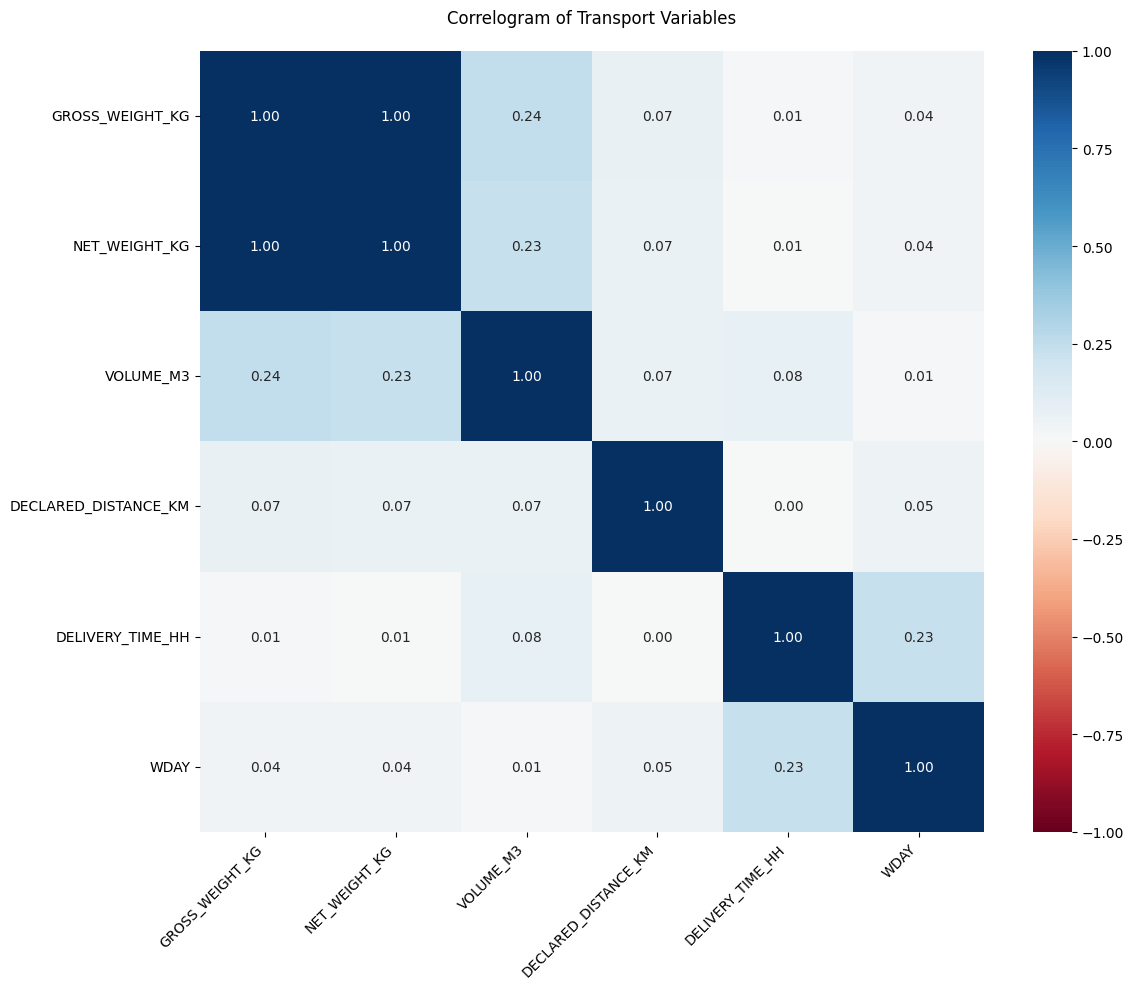

In [16]:
# Read the dataset
df = pd.read_csv('gomma_data.csv')

# Select only the numeric columns of interest
columns_of_interest = [
    'GROSS_WEIGHT_KG',
    'NET_WEIGHT_KG',
    'VOLUME_M3',
    'DECLARED_DISTANCE_KM',
    'DELIVERY_TIME_HH',
    'WDAY'
]

# Calculate the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Create a larger figure for better readability
plt.figure(figsize=(12, 10))

# Create the correlogram using seaborn
sns.heatmap(correlation_matrix, 
            annot=True,  # Show numeric values
            cmap='RdBu',  # Use a blue-red colormap
            vmin=-1, vmax=1,  # Set scale limits
            center=0,  # Center the colormap on zero
            fmt='.2f')  # Show two decimals

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add a title
plt.title('Correlogram of Transport Variables', pad=20)

# Adjust the layout
plt.tight_layout()

plt.show()

### Dataset Ecommerce

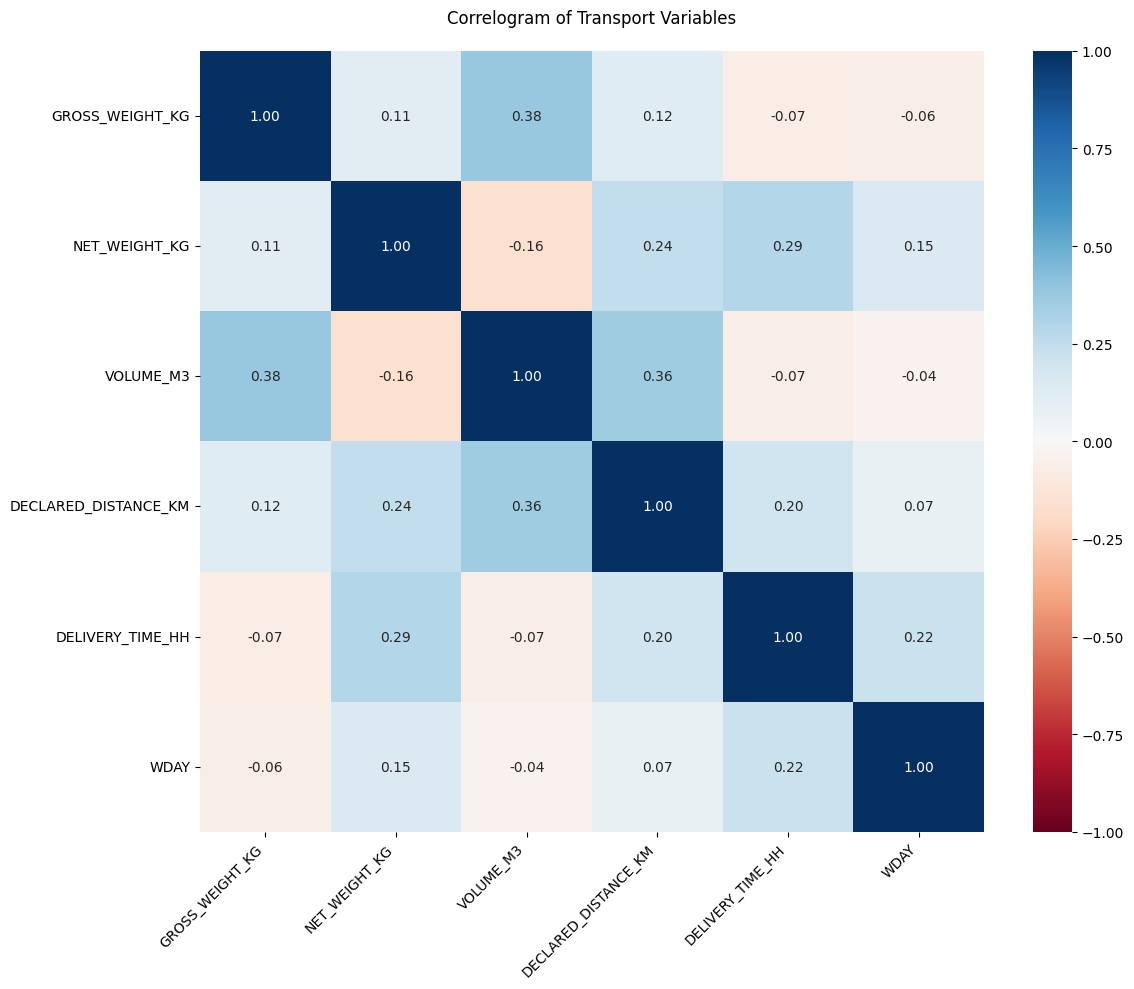

In [17]:
# Read the dataset
df = pd.read_csv('ecommerce_data.csv')

# Select only the numeric columns of interest
columns_of_interest = [
    'GROSS_WEIGHT_KG',
    'NET_WEIGHT_KG',
    'VOLUME_M3',
    'DECLARED_DISTANCE_KM',
    'DELIVERY_TIME_HH',
    'WDAY'
]

# Calculate the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Create a larger figure for better readability
plt.figure(figsize=(12, 10))

# Create the correlogram using seaborn
sns.heatmap(correlation_matrix, 
            annot=True,  # Show numeric values
            cmap='RdBu',  # Use a blue-red colormap
            vmin=-1, vmax=1,  # Set scale limits
            center=0,  # Center the colormap on zero
            fmt='.2f')  # Show two decimals

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add a title
plt.title('Correlogram of Transport Variables', pad=20)

# Adjust the layout
plt.tight_layout()

plt.show()

### Dataset Corrieri

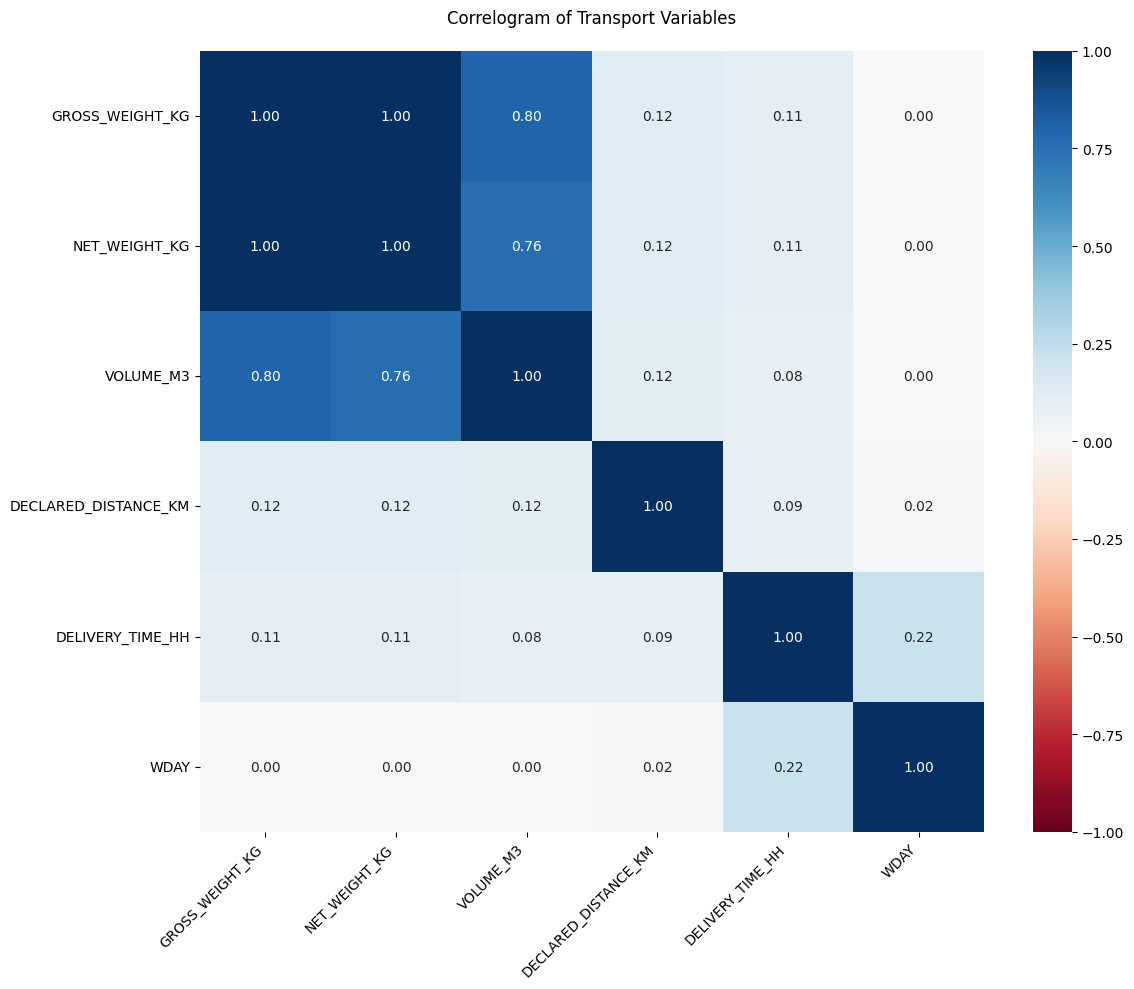

In [18]:
# Read the dataset
df = pd.read_csv('corrieri_data.csv')

# Select only the numeric columns of interest
columns_of_interest = [
    'GROSS_WEIGHT_KG',
    'NET_WEIGHT_KG',
    'VOLUME_M3',
    'DECLARED_DISTANCE_KM',
    'DELIVERY_TIME_HH',
    'WDAY'
]

# Calculate the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Create a larger figure for better readability
plt.figure(figsize=(12, 10))

# Create the correlogram using seaborn
sns.heatmap(correlation_matrix, 
            annot=True,  # Show numeric values
            cmap='RdBu',  # Use a blue-red colormap
            vmin=-1, vmax=1,  # Set scale limits
            center=0,  # Center the colormap on zero
            fmt='.2f')  # Show two decimals

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add a title
plt.title('Correlogram of Transport Variables', pad=20)

# Adjust the layout
plt.tight_layout()

plt.show()

### Final dataset

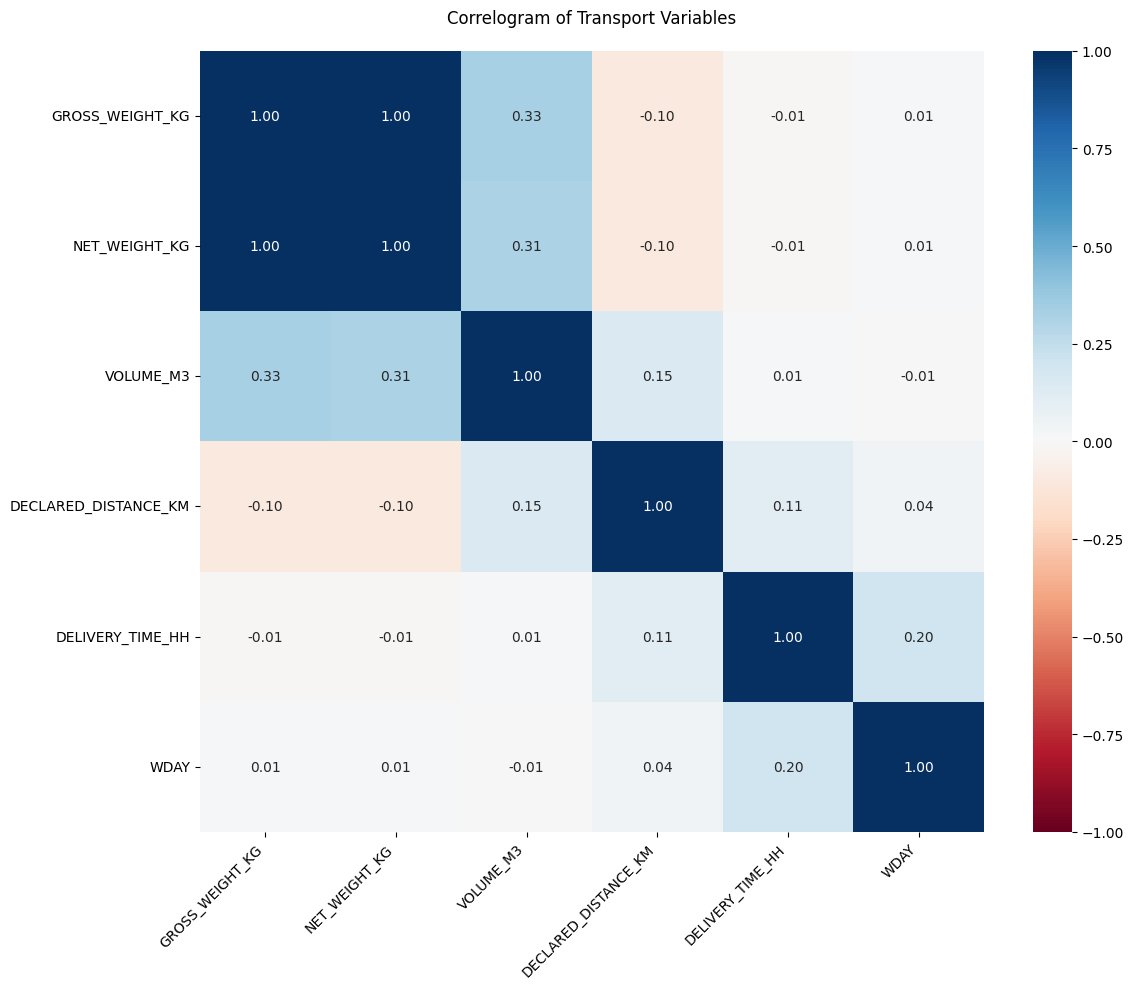

In [19]:
# Read the dataset
df = pd.read_csv('final_delivery_data.csv')

# Select only the numeric columns of interest
columns_of_interest = [
    'GROSS_WEIGHT_KG',
    'NET_WEIGHT_KG',
    'VOLUME_M3',
    'DECLARED_DISTANCE_KM',
    'DELIVERY_TIME_HH',
    'WDAY'
]

# Calculate the correlation matrix
correlation_matrix = df[columns_of_interest].corr()

# Create a larger figure for better readability
plt.figure(figsize=(12, 10))

# Create the correlogram using seaborn
sns.heatmap(correlation_matrix, 
            annot=True,  # Show numeric values
            cmap='RdBu',  # Use a blue-red colormap
            vmin=-1, vmax=1,  # Set scale limits
            center=0,  # Center the colormap on zero
            fmt='.2f')  # Show two decimals

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add a title
plt.title('Correlogram of Transport Variables', pad=20)

# Adjust the layout
plt.tight_layout()

plt.show()

Based on these correlations matrices we can understand that the thing that varies the most the delivery time is the day they leave, the more you are towards the weekend, the longer the delivery time will be

## Creation of average time histograms based on the day

We create 3 graphs for each type of transport system to see if there is any data that may interest us

### Histogram Gomma

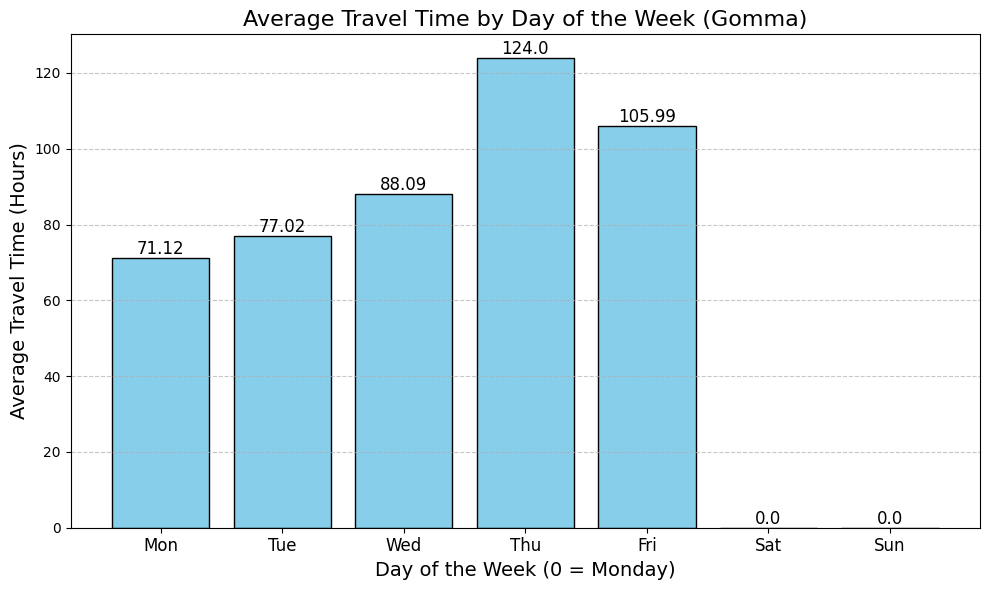

In [71]:
# Load the dataset
df_gomma = pd.read_csv('gomma_data.csv')

# Calculate the average delivery time for each day of the week
mean_delivery_time_gomma = df_gomma.groupby('WDAY')['DELIVERY_TIME_HH'].mean()

# Create a DataFrame with all days of the week
days_of_week = pd.DataFrame({'WDAY': range(7)})
mean_delivery_time_gomma = mean_delivery_time_gomma.reset_index()
mean_delivery_time_gomma = days_of_week.merge(mean_delivery_time_gomma, on='WDAY', how='left').fillna(0)

# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_delivery_time_gomma['WDAY'], mean_delivery_time_gomma['DELIVERY_TIME_HH'], color='skyblue', edgecolor='black')
plt.title('Average Travel Time by Day of the Week (Gomma)', fontsize=16)
plt.xlabel('Day of the Week (0 = Monday)', fontsize=14)
plt.ylabel('Average Travel Time (Hours)', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

### Histogram Corrieri

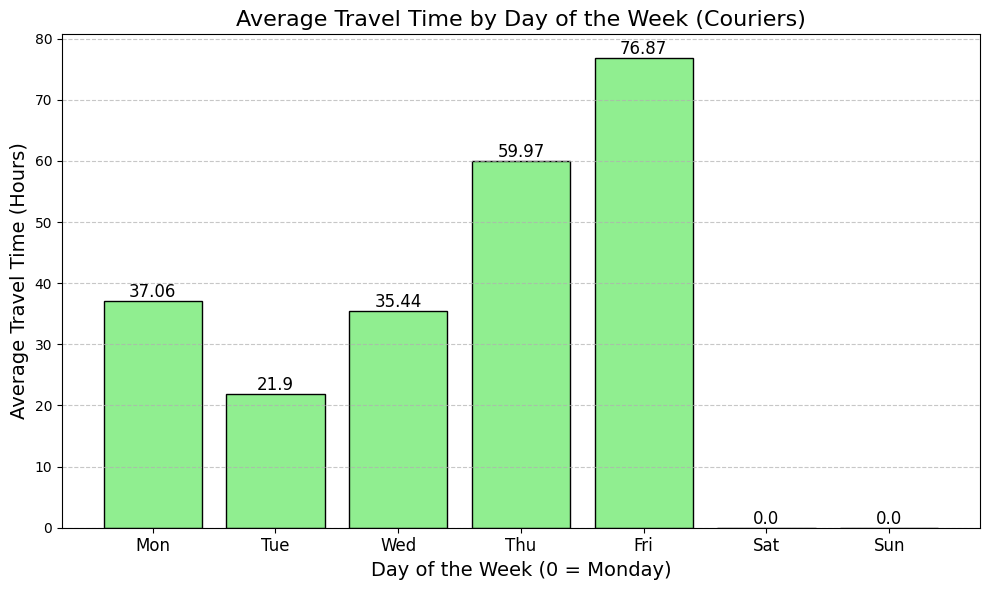

In [72]:
# Load the dataset
df_corrieri = pd.read_csv('corrieri_data.csv')

# Calculate the average delivery time for each day of the week
mean_delivery_time_corrieri = df_corrieri.groupby('WDAY')['DELIVERY_TIME_HH'].mean()

# Create a DataFrame with all days of the week
days_of_week = pd.DataFrame({'WDAY': range(7)})
mean_delivery_time_corrieri = mean_delivery_time_corrieri.reset_index()
mean_delivery_time_corrieri = days_of_week.merge(mean_delivery_time_corrieri, on='WDAY', how='left').fillna(0)

# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_delivery_time_corrieri['WDAY'], mean_delivery_time_corrieri['DELIVERY_TIME_HH'], color='lightgreen', edgecolor='black')
plt.title('Average Travel Time by Day of the Week (Couriers)', fontsize=16)
plt.xlabel('Day of the Week (0 = Monday)', fontsize=14)
plt.ylabel('Average Travel Time (Hours)', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

### Histogram E-commerce

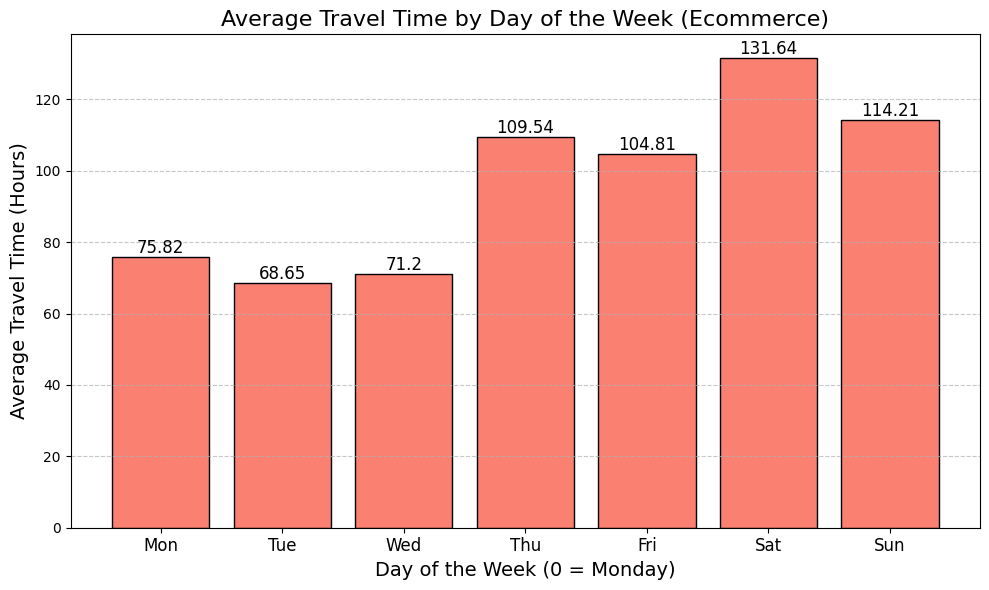

In [73]:
# Load the dataset
df_ecommerce = pd.read_csv('ecommerce_data.csv')

# Calculate the average delivery time for each day of the week
mean_delivery_time_ecommerce = df_ecommerce.groupby('WDAY')['DELIVERY_TIME_HH'].mean()

# Create a DataFrame with all days of the week
days_of_week = pd.DataFrame({'WDAY': range(7)})
mean_delivery_time_ecommerce = mean_delivery_time_ecommerce.reset_index()
mean_delivery_time_ecommerce = days_of_week.merge(mean_delivery_time_ecommerce, on='WDAY', how='left').fillna(0)

# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_delivery_time_ecommerce['WDAY'], mean_delivery_time_ecommerce['DELIVERY_TIME_HH'], color='salmon', edgecolor='black')
plt.title('Average Travel Time by Day of the Week (Ecommerce)', fontsize=16)
plt.xlabel('Day of the Week (0 = Monday)', fontsize=14)
plt.ylabel('Average Travel Time (Hours)', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

Analyzing these data we can understand that, in case the service is Via gomma or Corriere espresso, do not accept packages during the weekend. These data can be used to create the prediction algorithm.

## We divide the final file into 3 according to where the orders start and arrive

In [20]:
def split_csv(input_file):
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    # Filter for IT-IT deliveries
    it_it = df[(df['DEPARTURE_COUNTRY'] == 'IT') & (df['ARRIVAL_COUNTRY'] == 'IT')]
    it_it.to_csv('final_delivery_data_it_it.csv', index=False)
    
    # Filter for US-US deliveries
    us_us = df[(df['DEPARTURE_COUNTRY'] == 'US') & (df['ARRIVAL_COUNTRY'] == 'US')]
    us_us.to_csv('final_delivery_data_us_us.csv', index=False)
    
    # Filter for mixed IT-US or US-IT deliveries
    mixed = df[
        ((df['DEPARTURE_COUNTRY'] == 'IT') & (df['ARRIVAL_COUNTRY'] == 'US')) |
        ((df['DEPARTURE_COUNTRY'] == 'US') & (df['ARRIVAL_COUNTRY'] == 'IT'))
    ]
    mixed.to_csv('final_delivery_data_mixed.csv', index=False)
    
    # Print summary
    print(f"IT-IT deliveries: {len(it_it)}")
    print(f"US-US deliveries: {len(us_us)}")
    print(f"Mixed deliveries: {len(mixed)}")

# Run the splitting
split_csv('final_delivery_data.csv')

IT-IT deliveries: 11755
US-US deliveries: 2225
Mixed deliveries: 574


## Creation of the travel map

In [22]:
def get_zipcode_coordinates(zipcode: str, country: str) -> Optional[Tuple[float, float]]:
    try:
        geolocator = Nominatim(user_agent="delivery_route_mapper")
        location = geolocator.geocode(f"{zipcode}, {country}")
        
        if location:
            return (location.latitude, location.longitude)
        return None
    except Exception as e:
        print(f"Error getting coordinates for {zipcode}, {country}: {str(e)}")
        return None

def disegnaMappa(nomeFilecsv: str):
    try:
        # Read only first 50 rows
        dataSet = pd.read_csv(nomeFilecsv, nrows=50)
        viaggi = []
        citta = {}
        
        # Progress bar for geocoding
        for _, row in tqdm(dataSet.iterrows(), total=dataSet.shape[0], desc=f"Processing {nomeFilecsv}"):
            partenza = get_zipcode_coordinates(str(row["DEPARTURE_ZIPCODE"]), row["DEPARTURE_COUNTRY"])
            arrivo = get_zipcode_coordinates(str(row["ARRIVAL_ZIPCODE"]), row["ARRIVAL_COUNTRY"])
            
            if arrivo is not None and partenza is not None:
                tratta = [partenza, arrivo]
                viaggi.append(tratta)
                citta[str(row["DEPARTURE_ZIPCODE"])] = partenza
                citta[str(row["ARRIVAL_ZIPCODE"])] = arrivo
            
            time.sleep(1)  # Prevent overwhelming the geocoding service
        
        # Create map
        mappa = folium.Map(location=[45, 10], zoom_start=4)
        
        # Add routes
        for viaggio in tqdm(viaggi, desc="Adding Routes"):
            folium.PolyLine(viaggio, color="blue", weight=2, opacity=0.7).add_to(mappa)
        
        # Add markers
        for nome, coord in tqdm(citta.items(), desc="Adding Markers"):
            folium.Marker(coord, popup=nome, icon=folium.Icon(color="red")).add_to(mappa)
        
        # Save map in current directory
        output_name = os.path.splitext(nomeFilecsv)[0] + '_sample.html'
        mappa.save(output_name)
        print(f"Sample map successfully created: {output_name}")
        return True
    
    except Exception as e:
        print(f"Error processing {nomeFilecsv}: {e}")
        return False

def main():
    files = [
        'final_delivery_data_it_it.csv',
        'final_delivery_data_us_us.csv', 
        'final_delivery_data_mixed.csv'
    ]

    for file in files:
        if os.path.exists(file):
            disegnaMappa(file)
        else:
            print(f"File not found: {file}")

if __name__ == "__main__":
    main()

Adding Markers: 100%|██████████| 36/36 [00:00<00:00, 18450.02it/s]


Sample map successfully created: final_delivery_data_it_it_sample.html


Adding Markers: 100%|██████████| 59/59 [00:00<00:00, 8544.73it/s]


Sample map successfully created: final_delivery_data_us_us_sample.html


Adding Markers: 100%|██████████| 49/49 [00:00<00:00, 25530.55it/s]

Sample map successfully created: final_delivery_data_mixed_sample.html


## Finally we create a code to predict the distance in km and delivery time

In [53]:
# Required imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

class DeliveryPredictor:
    def __init__(self):
        self.le_service = LabelEncoder()
        self.le_vehicle = LabelEncoder()
        self.le_dep_country = LabelEncoder()
        self.le_arr_country = LabelEncoder()
        self.le_dep_zip = LabelEncoder()
        self.le_arr_zip = LabelEncoder()
        self.scaler = RobustScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.distance_model = GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        self.time_model = GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        self.unique_values = {}
        
    def prepare_data(self, df):
        df = df.copy()
        
        # Clean zip codes
        df['DEPARTURE_ZIPCODE'] = df['DEPARTURE_ZIPCODE'].fillna('00000')
        df['ARRIVAL_ZIPCODE'] = df['ARRIVAL_ZIPCODE'].fillna('00000')
        df['DEPARTURE_ZIPCODE'] = df['DEPARTURE_ZIPCODE'].astype(str).str.replace('.0', '').str.zfill(5)
        df['ARRIVAL_ZIPCODE'] = df['ARRIVAL_ZIPCODE'].astype(str).str.replace('.0', '').str.zfill(5)
        
        # Remove rows with NaN in critical columns
        critical_columns = ['DELIVERY_TIME_HH', 'DECLARED_DISTANCE_KM', 'SERVICETYPE', 'VEHICLETYPE', 
                            'DEPARTURE_COUNTRY', 'ARRIVAL_COUNTRY', 'WDAY']
        df.dropna(subset=critical_columns, inplace=True)
        
        # Remove outliers from delivery time
        q1 = df['DELIVERY_TIME_HH'].quantile(0.25)
        q3 = df['DELIVERY_TIME_HH'].quantile(0.75)
        iqr = q3 - q1
        df = df[
            (df['DELIVERY_TIME_HH'] >= q1 - 1.5 * iqr) & 
            (df['DELIVERY_TIME_HH'] <= q3 + 1.5 * iqr)
        ]
        
        # Add derived features
        df['SAME_COUNTRY'] = (df['DEPARTURE_COUNTRY'] == df['ARRIVAL_COUNTRY']).astype(int)
        
        # Encode categorical variables
        df['SERVICETYPE_encoded'] = self.le_service.fit_transform(df['SERVICETYPE'])
        df['VEHICLETYPE_encoded'] = self.le_vehicle.fit_transform(df['VEHICLETYPE'])
        df['DEPARTURE_COUNTRY_encoded'] = self.le_dep_country.fit_transform(df['DEPARTURE_COUNTRY'])
        df['ARRIVAL_COUNTRY_encoded'] = self.le_arr_country.fit_transform(df['ARRIVAL_COUNTRY'])
        df['DEPARTURE_ZIPCODE_encoded'] = self.le_dep_zip.fit_transform(df['DEPARTURE_ZIPCODE'])
        df['ARRIVAL_ZIPCODE_encoded'] = self.le_arr_zip.fit_transform(df['ARRIVAL_ZIPCODE'])
        
        # Store unique values
        self.unique_values = {
            'service_types': df['SERVICETYPE'].unique(),
            'vehicle_types': df['VEHICLETYPE'].unique(),
            'departure_countries': df['DEPARTURE_COUNTRY'].unique(),
            'arrival_countries': df['ARRIVAL_COUNTRY'].unique(),
            'departure_zipcodes': df['DEPARTURE_ZIPCODE'].unique(),
            'arrival_zipcodes': df['ARRIVAL_ZIPCODE'].unique()
        }
        
        # Prepare features
        features = [
            'SERVICETYPE_encoded', 'VEHICLETYPE_encoded', 
            'DEPARTURE_COUNTRY_encoded', 'ARRIVAL_COUNTRY_encoded',
            'DEPARTURE_ZIPCODE_encoded', 'ARRIVAL_ZIPCODE_encoded', 
            'WDAY', 'SAME_COUNTRY'
        ]
        
        # Add DISTANCE_ENCODED
        if 'DECLARED_DISTANCE_KM' in df.columns:
            df['DISTANCE_ENCODED'] = self.scaler.fit_transform(df[['DECLARED_DISTANCE_KM']])
        else:
            df['DISTANCE_ENCODED'] = 0
        
        features.append('DISTANCE_ENCODED')
        
        # Prepare X with imputation
        X = df[features].values
        X = self.imputer.fit_transform(X)  # Impute missing values
        X = self.scaler.fit_transform(X)
        
        return X, df

    def train(self, data_path):
        # Load data
        df = pd.read_csv(data_path)
        
        # Prepare features and targets
        X, df_cleaned = self.prepare_data(df)
        y_distance = df_cleaned['DECLARED_DISTANCE_KM'].values
        y_time = df_cleaned['DELIVERY_TIME_HH'].values
        
        # Normalize delivery time
        y_time = np.minimum(y_time, 72)
        
        # Split data
        X_train, X_test, y_dist_train, y_dist_test, y_time_train, y_time_test = train_test_split(
            X, y_distance, y_time, test_size=0.2, random_state=42
        )
        
        # Train models
        self.distance_model.fit(X_train, y_dist_train)
        self.time_model.fit(X_train, y_time_train)
        
        # Calculate accuracy
        dist_accuracy = r2_score(y_dist_test, self.distance_model.predict(X_test))
        time_accuracy = r2_score(y_time_test, self.time_model.predict(X_test))
        
        return dist_accuracy, time_accuracy

    def custom_round(self, number):
        """Custom rounding function based on decimal part"""
        decimal_part = number % 1
        if decimal_part >= 0.5:
            return np.ceil(number)
        return np.floor(number)
    
    def predict(self, service_type, vehicle_type, departure_country, arrival_country,
                departure_zipcode, arrival_zipcode, departure_date):
        # Convert departure_date to weekday
        departure_dt = datetime.strptime(departure_date, '%Y-%m-%d')
        wday = departure_dt.weekday()
        
        # Convert zip codes to strings with leading zeros
        departure_zipcode = str(departure_zipcode).replace('.0', '').zfill(5)
        arrival_zipcode = str(arrival_zipcode).replace('.0', '').zfill(5)
        
        # Calculate same country feature
        same_country = 1 if departure_country == arrival_country else 0
        
        # Prepare input data
        input_data = np.array([[
            self.le_service.transform([service_type])[0],
            self.le_vehicle.transform([vehicle_type])[0],
            self.le_dep_country.transform([departure_country])[0],
            self.le_arr_country.transform([arrival_country])[0],
            self.le_dep_zip.transform([departure_zipcode])[0],
            self.le_arr_zip.transform([arrival_zipcode])[0],
            wday,
            same_country,
            0  # Default DISTANCE_ENCODED
        ]])
        
        input_scaled = self.scaler.transform(input_data)
        
        # Make predictions
        predicted_distance = self.distance_model.predict(input_scaled)[0]
        model_predicted_hours = self.time_model.predict(input_scaled)[0]
        
        # Limit predicted hours from model
        model_predicted_hours = min(model_predicted_hours, 72)
        # Apply custom rounding to model_predicted_hours
        model_predicted_hours = self.custom_round(model_predicted_hours)
        
        # Calculate workdays and arrival date based on model_predicted_hours
        work_hours_per_day = 8
        total_workdays = int(np.ceil(model_predicted_hours / work_hours_per_day))
        
        # Calculate arrival date considering weekends
        arrival_date = departure_dt
        actual_workdays = 0
        
        while actual_workdays < total_workdays:
            arrival_date += timedelta(days=1)
            # Only count weekdays
            if arrival_date.weekday() < 7:  # Monday = 0, Friday = 4
                actual_workdays += 1
        
        # Adjust arrival date for weekend only for non-E-commerce services
        if service_type not in ["E-commerce", "E-commerce resi"]:
            arrival_weekday = arrival_date.weekday()
            if arrival_weekday == 5:  # Saturday
                arrival_date += timedelta(days=2)  # Move to Monday
            elif arrival_weekday == 6:  # Sunday
                arrival_date += timedelta(days=1)  # Move to Monday

        # Calculate actual hours between dates
        total_days = (arrival_date - departure_dt).days
        predicted_hours = total_days * 24  # Convert days to hours
        
        return {
            'predicted_distance_km': round(predicted_distance, 2),
            'predicted_hours': predicted_hours,
            'total_work_hours': model_predicted_hours,  # Using the rounded model prediction
            'total_work_days': total_workdays,
            'predicted_arrival_date': arrival_date.strftime('%Y-%m-%d'),
            'weekend_adjusted': arrival_date.weekday() == 0 and departure_dt.weekday() < 5
        }

def main():
    predictor = DeliveryPredictor()
    # Training
    try:
        dist_acc, time_acc = predictor.train("final_delivery_data.csv")
        print(f"Distance model accuracy: {dist_acc*100:.2f}%")
        print(f"Time model accuracy: {time_acc*100:.2f}%")
        
        # Example prediction
        prediction = predictor.predict(
            service_type="Corriere espresso",
            vehicle_type="Express",
            departure_country="IT",
            arrival_country="IT",
            departure_zipcode="62010",
            arrival_zipcode="22100",
            departure_date="2023-01-10"
        )
        
        print("\nPrediction:")
        for key, value in prediction.items():
            print(f"{key.replace('_', ' ').title()}: {value}")
    
    except FileNotFoundError:
        print("Error: 'final_delivery_data.csv' not found. Please ensure the data file exists.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Distance model accuracy: 100.00%
Time model accuracy: 55.95%

Prediction:
Predicted Distance Km: 427.3
Predicted Hours: 144
Total Work Hours: 31.0
Total Work Days: 4
Predicted Arrival Date: 2023-01-16
Weekend Adjusted: True
